In [2]:
import time
from collections import deque, namedtuple

import gym
import numpy as np
import PIL.Image
import tensorflow as tf
import utils

# from pyvirtualdisplay import Display
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

from environment import TrafficLightEnv

In [3]:
tf.random.set_seed(utils.SEED)

<a name="2"></a>
## 2 - Hyperparameters

In [4]:
ROAD_COUNTS = 4
CHANGE_SIZE = 10
MAX_STATE_VALUE = 400

In [5]:
MEMORY_SIZE = 100_000       # size of memory buffer
GAMMA = 0.995               # discount factor
ALPHA = 1e-2                # learning rate  
NUM_STEPS_FOR_UPDATE = 100  # perform a learning update every C time steps

In [6]:
env = TrafficLightEnv(roads_count=ROAD_COUNTS,change_size=CHANGE_SIZE,max_value=MAX_STATE_VALUE)

In [7]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (16,)
Number of actions: 15


In [8]:
# Reset the environment and get the initial state.
current_state = env.reset()

In [9]:
# Select an action
action = 0

# Run a single time step of the environment's dynamics with the given action.
next_state, reward, done, _ = env.step(action)

# Display table with values.
# utils.display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

In [10]:
# UNQ_C1
# GRADED CELL

# Create the Q-Network
q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=32, activation='relu'),            
    # Dense(units=64, activation='relu'),            
    # Dense(units=128, activation='relu'),            
    # Dense(units=256, activation='relu'),            
    # Dense(units=512, activation='relu'),            
    # Dense(units=1024, activation='relu'),            
    # Dense(units=512, activation='relu'),            
    # Dense(units=256, activation='relu'),            
    # Dense(units=128, activation='relu'),            
    # Dense(units=64, activation='relu'),            
    # Dense(units=32, activation='relu'),            
    Dense(units=num_actions, activation='linear'),
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    Input(shape=state_size),                      
    Dense(units=32, activation='relu'),            
    # Dense(units=64, activation='relu'),            
    # Dense(units=128, activation='relu'),            
    # Dense(units=256, activation='relu'),            
    # Dense(units=512, activation='relu'),            
    # Dense(units=1024, activation='relu'),            
    # Dense(units=512, activation='relu'),            
    # Dense(units=256, activation='relu'),            
    # Dense(units=128, activation='relu'),            
    # Dense(units=64, activation='relu'),            
    # Dense(units=32, activation='relu'),             
    Dense(units=num_actions, activation='linear'),
    ])

optimizer = Adam(learning_rate=ALPHA)

q_network.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 15)                495       
                                                                 
Total params: 1,039
Trainable params: 1,039
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [12]:
def compute_loss(experiences, gamma, q_network, target_q_network):

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences
    
    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)
    
    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ### 
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###
    
    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))
        
    # Compute the loss
    ### START CODE HERE ### 
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ### 
    
    return loss

In [13]:
@tf.function
def agent_learn(experiences, gamma):
    
    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)
    
    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [14]:
start = time.time()

num_episodes = 1000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):
    
    # Reset the environment to the initial state and get the initial state
    state = env.reset()
    total_points = []
    
    for t in range(max_num_timesteps):
        
        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)
        
        # Take action A and receive reward R and the next state S'
        next_state, reward, done, _ = env.step(action)
        
        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))
        
        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)
        
        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)
            
            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)
        
        state = next_state.copy()
        total_points.append(reward)
        
        if done:
            break
            
    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])
    
    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # env.render()
    # print('\n')

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break
        
tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -2782.92
Episode 200 | Total point average of the last 100 episodes: -2827.16
Episode 300 | Total point average of the last 100 episodes: -2672.94
Episode 400 | Total point average of the last 100 episodes: -2763.06
Episode 500 | Total point average of the last 100 episodes: -2773.14
Episode 600 | Total point average of the last 100 episodes: -2854.33
Episode 700 | Total point average of the last 100 episodes: -2750.28
Episode 800 | Total point average of the last 100 episodes: -2744.77
Episode 900 | Total point average of the last 100 episodes: -2740.23
Episode 1000 | Total point average of the last 100 episodes: -2634.99

Total Runtime: 128.40 s (2.14 min)


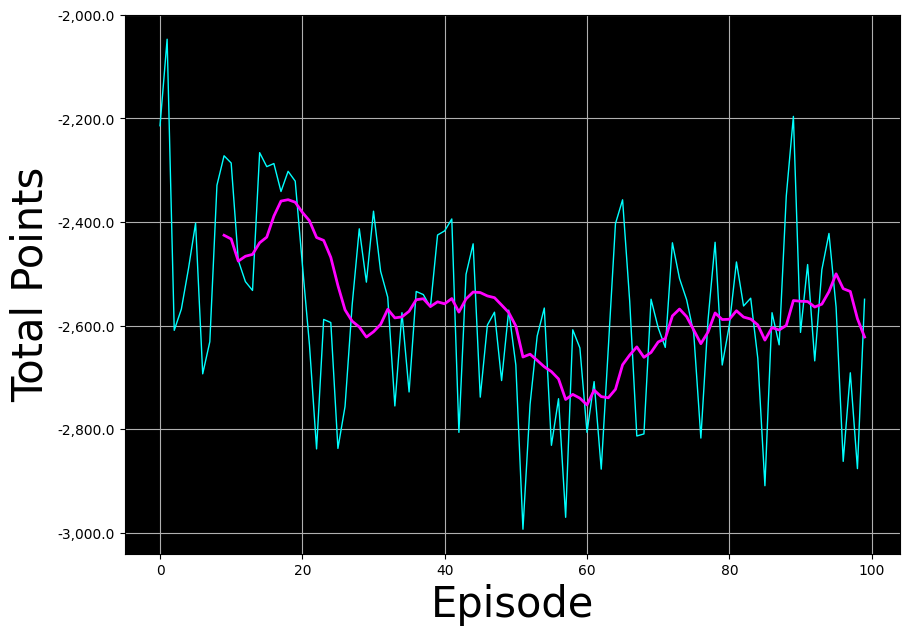

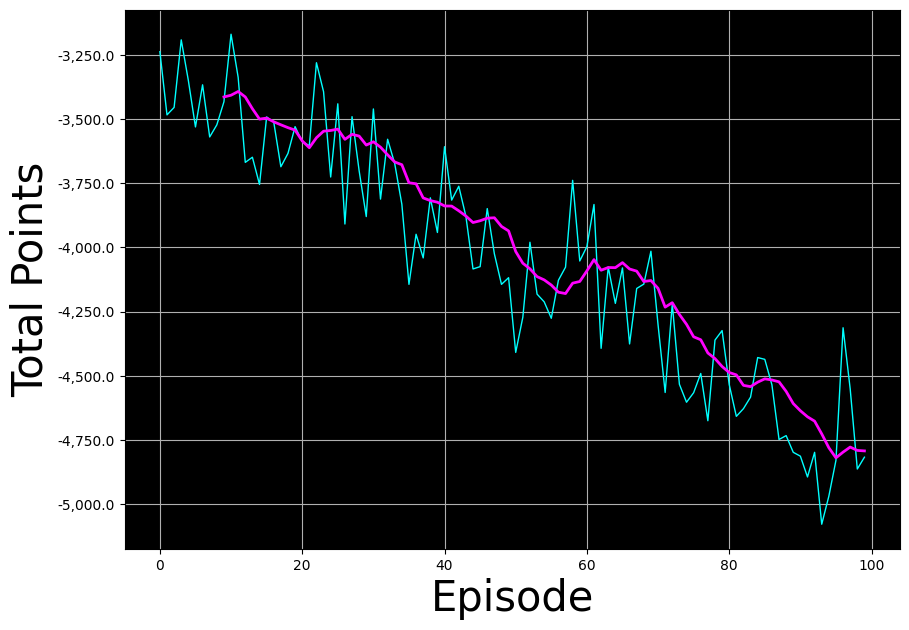

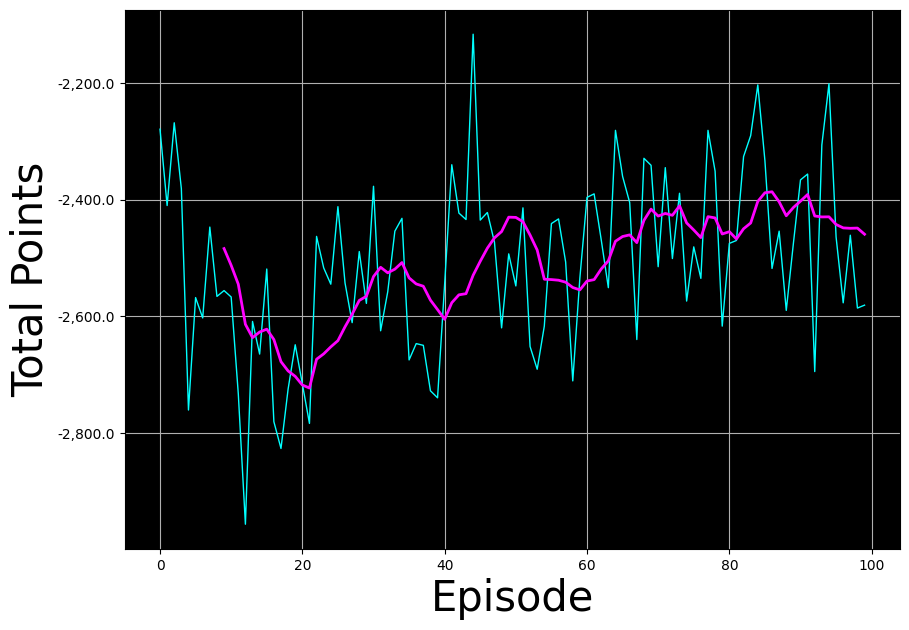

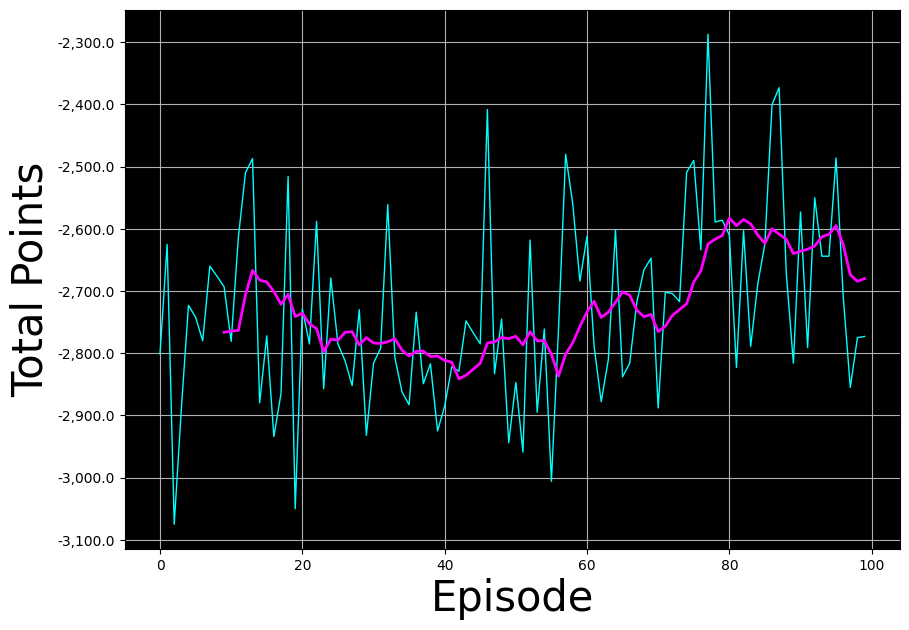

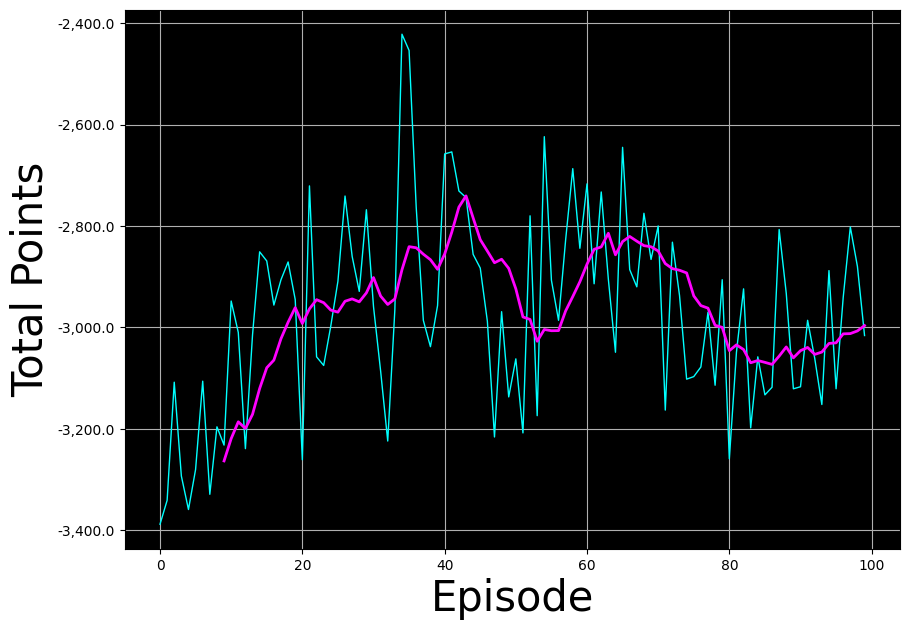

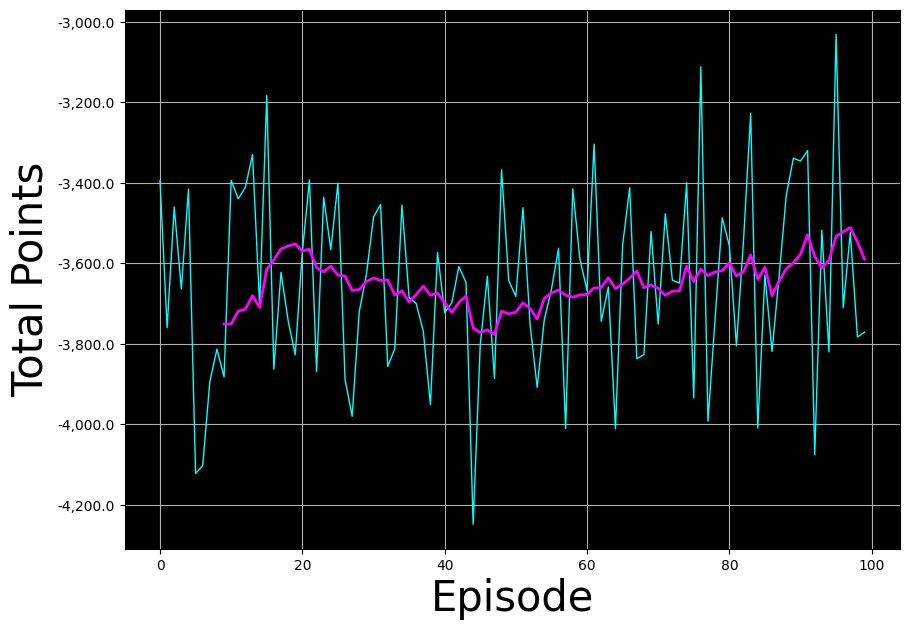

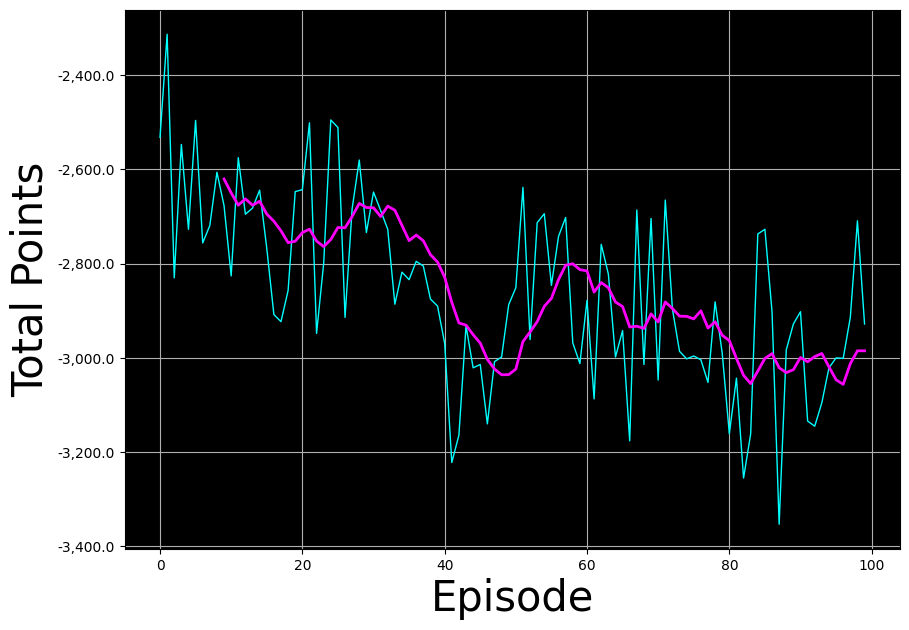

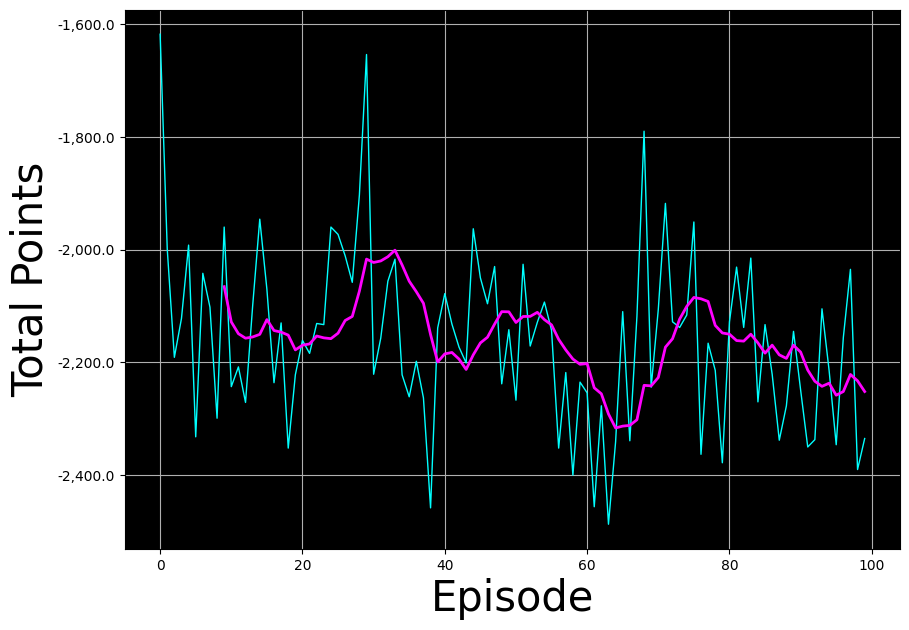

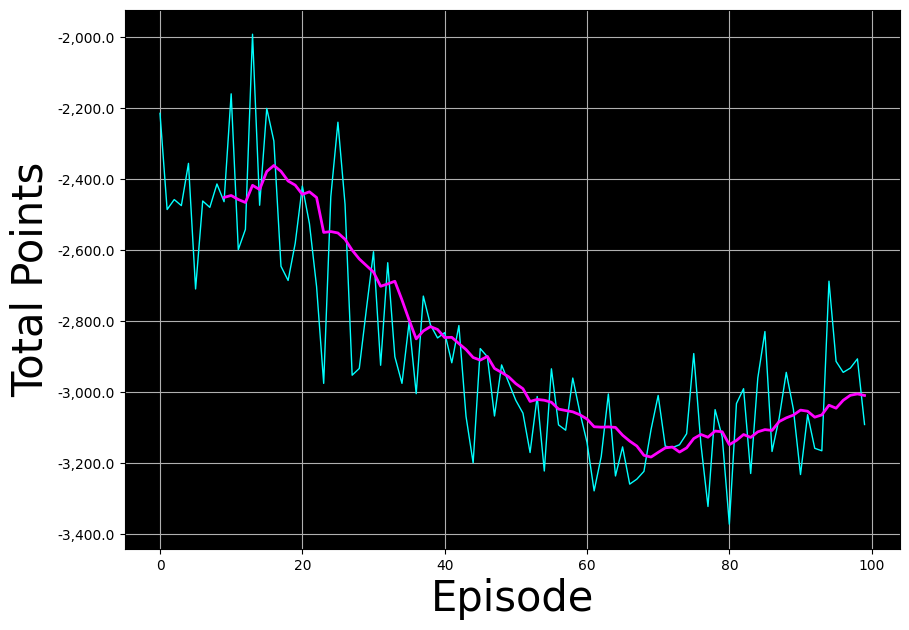

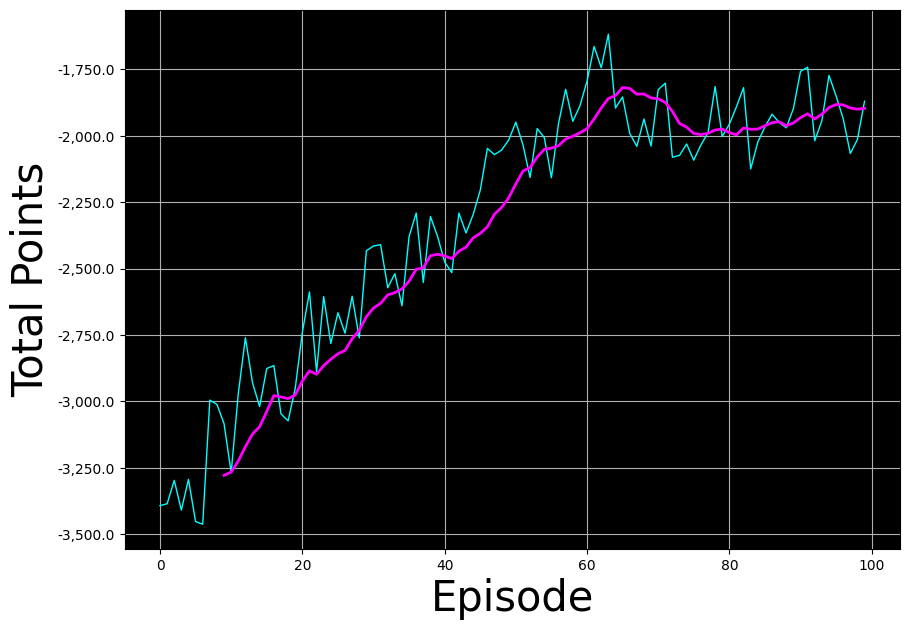

In [15]:
for episode in range(0, num_episodes, num_episodes//10):
    utils.plot_history(total_point_history[episode])

In [17]:
state = env.reset()
done = False
test_reward = []
while not done:
    env.render()
    state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
    q_values = q_network(state_qn)
    action = utils.get_action(q_values, epsilon)
    # Take action A and receive reward R and the next state S'
    next_state, reward, done, _ = env.step(action)
    # Store experience tuple (S,A,R,S') in the memory buffer.
    # We store the done variable as well for convenience.
    memory_buffer.append(experience(state, action, reward, next_state, done))
    print('action taken:', env.cast_action(action))
    print('reward:', reward)
    print('')
env.render()

green light timer [176. 306.  16. 138.]
avg waiting times (-) [460. 330. 620. 498.]
vehicles counts (-) [309. 106. 285. 325.]
in counts (+) [148. 124. 325.  72.]
action taken: [1 1 2 1 1]
reward: -2631.0

green light timer [176. 306.  26. 138.]
avg waiting times (-) [470. 340. 620. 508.]
vehicles counts (-) [317. 207. 279. 285.]
in counts (+) [176. 106.  26. 138.]
action taken: [1 1 2 1 1]
reward: -2482.0

green light timer [176. 306.  36. 138.]
avg waiting times (-) [480. 350. 620. 518.]
vehicles counts (-) [338.  29. 344. 339.]
in counts (+) [176. 207.  36. 138.]
action taken: [1 1 2 1 1]
reward: -2790.0

green light timer [176. 306.  46. 138.]
avg waiting times (-) [490. 360. 620. 528.]
vehicles counts (-) [380. 162. 351. 309.]
in counts (+) [176.  29.  46. 138.]
action taken: [1 1 2 1 1]
reward: -2666.0

green light timer [176. 306.  56. 138.]
avg waiting times (-) [500. 370. 620. 538.]
vehicles counts (-) [335. 320. 386. 277.]
in counts (+) [176. 162.  56. 138.]
action taken: [1 1

<a name="12"></a>
## 12 - References

If you would like to learn more about Deep Q-Learning, we recommend you check out the following papers.


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Human-level control through deep reinforcement learning. Nature 518, 529–533 (2015).


* Lillicrap, T. P., Hunt, J. J., Pritzel, A., et al. Continuous Control with Deep Reinforcement Learning. ICLR (2016).


* Mnih, V., Kavukcuoglu, K., Silver, D. et al. Playing Atari with Deep Reinforcement Learning. arXiv e-prints.  arXiv:1312.5602 (2013).

<details>
  <summary><font size="2" color="darkgreen"><b>Please click here if you want to experiment with any of the non-graded code.</b></font></summary>
    <p><i><b>Important Note: Please only do this when you've already passed the assignment to avoid problems with the autograder.</b></i>
    <ol>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “Edit Metadata”</li>
        <li> Hit the “Edit Metadata” button next to the code cell which you want to lock/unlock</li>
        <li> Set the attribute value for “editable” to:
            <ul>
                <li> “true” if you want to unlock it </li>
                <li> “false” if you want to lock it </li>
            </ul>
        </li>
        <li> On the notebook’s menu, click “View” > “Cell Toolbar” > “None” </li>
    </ol>
    <p> Here's a short demo of how to do the steps above: 
        <br>
        <img src="https://drive.google.com/uc?export=view&id=14Xy_Mb17CZVgzVAgq7NCjMVBvSae3xO1" align="center" alt="unlock_cells.gif">
</details>